In [1]:
import os
import glob
import json
import cv2
import numpy as np                  
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm

In [10]:
# Input
TRAIN_CSV_RSNA_PATH = "./input/train_rsna.csv"
TRAIN_CSV_INBREAST_PATH = "./input/train_inbreast.xls"
TRAIN_CSV_INBREAST_META_PATH = "./input/train_inbreast_metadata.csv"
TRAIN_CSV_CMMD_PATH = "./input/train_cmmd.csv"

TRAIN_INPUT_IMG_RSNA_PATH = "./images_rsna/"
TRAIN_INPUT_IMG_INBREAST_PATH = "./images_inbreast/"
TRAIN_INPUT_IMG_CMMD_PATH = "./images_cmmd/"

# Output
DATASET_NAME = f"RSNA+CCDM+INBREAST"
SAVE_FOLDER = f"./output/{DATASET_NAME}"

In [11]:
df_train_rsna = pd.read_csv(TRAIN_CSV_RSNA_PATH)
print("-------------- RSNA -------------")
print(f"Number of images: {len(df_train_rsna)}")
print(f"Number of cancer images: {len(df_train_rsna[(df_train_rsna.cancer == 1)])}")
print(f"Number of implant images: {len(df_train_rsna[(df_train_rsna.implant == 1)])}")
print(f"Number of cancer&implant images: {len(df_train_rsna[((df_train_rsna.implant == 1) & (df_train_rsna.cancer == 1))])}")
df_train_rsna.head()

-------------- RSNA -------------
Number of images: 54706
Number of cancer images: 1158
Number of implant images: 1477
Number of cancer&implant images: 13


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [12]:
df_train_inbreast1 = pd.read_excel(TRAIN_CSV_INBREAST_PATH, "Sheet1")
df_train_inbreast2 = pd.read_excel(TRAIN_CSV_INBREAST_PATH, "Sheet2") # Read sheet 2
df_train_inbreast_meta = pd.read_csv(TRAIN_CSV_INBREAST_META_PATH)
print("-------------- INBREAST -------------")
print(f"Number of images: {len(df_train_inbreast2)}")
df_train_inbreast2 = df_train_inbreast2.rename(columns={"Bi-Rads": "birads"})
df_train_inbreast2.drop(df_train_inbreast2[(df_train_inbreast2.birads == 47)].index, inplace=True)
print(df_train_inbreast2.groupby(["birads"]).size())
print(f"Number of cancer images: {len(df_train_inbreast2[(df_train_inbreast2.birads == 5) | (df_train_inbreast2.birads == 6) | (df_train_inbreast2.birads == '4c')])}")
df_train_inbreast = df_train_inbreast2.join(df_train_inbreast1["File Name"], how="right")
df_train_inbreast

-------------- INBREAST -------------
Number of images: 412
birads
1      65
2     224
3      23
5      47
6       8
4a     13
4b      8
4c     22
dtype: int64
Number of cancer images: 77


,Patient ID,Patient age,Acquisition date,birads,DG,File Name
0,10455721.0,68.0,20090826.0,2,Ca Invasor,22678622.0
1,10455721.0,68.0,20090826.0,5,NaN,22678646.0
2,10455721.0,68.0,20090826.0,2,NaN,22678670.0
3,10455721.0,68.0,20090826.0,5,NaN,22678694.0
4,10904633.0,64.0,20090825.0,4c,CDIS,22614074.0
...,...,...,...,...,...,...
407,11062829.0,57.0,20100312.0,1,NaN,24055752.0
408,11062829.0,57.0,20100312.0,2,NaN,24055779.0
409,11062829.0,57.0,20100312.0,1,NaN,24055806.0
410,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df_train_inbreast_meta.head()

,Unnamed: 0,Patient ID,File_path
0,0,10455721.0,"['20586908_6c613a14b80a8591_MG_R_CC_ANON.png',..."
1,1,10904633.0,"['20587054_b6a4f750c6df4f90_MG_R_CC_ANON.png',..."
2,2,11223500.0,"['20587148_fd746d25eb40b3dc_MG_R_CC_ANON.png',..."
3,3,10462380.0,"['20587294_e634830794f5c1bd_MG_R_CC_ANON.png',..."
4,4,10772099.0,"['20587466_d571b5880ad2a016_MG_L_CC_ANON.png',..."


In [14]:
file_paths = [df_train_inbreast_meta[(df_train_inbreast_meta["Patient ID"] == x)]["File_path"] for x in df_train_inbreast2["Patient ID"].drop_duplicates()]
file_paths_list = []
for i in range(len(df_train_inbreast_meta)):
    file_paths_list.extend(list(map(str, file_paths[i][i][1:-1].split(','))))
file_paths_stripped = []
for path in file_paths_list:
    file_paths_stripped.append(f"{TRAIN_INPUT_IMG_INBREAST_PATH}{path.strip()[1:-1]}")

image_paths_df = pd.DataFrame(file_paths_stripped, columns=["image_path"])
df_train_inbreast = df_train_inbreast.join(image_paths_df, how="right")
df_train_inbreast

,Patient ID,Patient age,Acquisition date,birads,DG,File Name,image_path
0,10455721.0,68.0,20090826.0,2,Ca Invasor,22678622.0,./images_inbreast/20586908_6c613a14b80a8591_MG...
1,10455721.0,68.0,20090826.0,5,NaN,22678646.0,./images_inbreast/20586934_6c613a14b80a8591_MG...
2,10455721.0,68.0,20090826.0,2,NaN,22678670.0,./images_inbreast/20586960_6c613a14b80a8591_MG...
3,10455721.0,68.0,20090826.0,5,NaN,22678694.0,./images_inbreast/20586986_6c613a14b80a8591_MG...
4,10904633.0,64.0,20090825.0,4c,CDIS,22614074.0,./images_inbreast/20587054_b6a4f750c6df4f90_MG...
...,...,...,...,...,...,...,...
405,11359531.0,59.0,20100312.0,2,NaN,22613848.0,./images_inbreast/53587599_11e6732579acf692_MG...
406,11062829.0,57.0,20100312.0,2,NaN,24055725.0,./images_inbreast/53587663_5fb370d4c1c71974_MG...
407,11062829.0,57.0,20100312.0,1,NaN,24055752.0,./images_inbreast/53587690_5fb370d4c1c71974_MG...
408,11062829.0,57.0,20100312.0,2,NaN,24055779.0,./images_inbreast/53587717_5fb370d4c1c71974_MG...


In [15]:
df_train_cmmd = pd.read_csv(TRAIN_CSV_CMMD_PATH)
print("-------------- CMMD -------------")
print(f"Number of images: {len(df_train_cmmd)}")
print(f"Number of cancer images: {len(df_train_cmmd[(df_train_cmmd.Classification == 'Malignant')])}")
df_train_cmmd.head()

-------------- CMMD -------------
Number of images: 5202
Number of cancer images: 4094


,ID,LeftRight,Age,Abnormality,Classification,Subtype,Path,Method_crop
0,D1-0033,R,57,calcification,Benign,NaN,Cancer/D1-0033_1-2.png,Yolo
1,D1-0033,R,57,calcification,Benign,NaN,Cancer/D1-0033_1-1.png,Yolo
2,D2-0230,L,60,both,Malignant,HER2-enriched,Cancer/D2-0230_1-2.png,Yolo
3,D2-0230,L,60,both,Malignant,HER2-enriched,Cancer/D2-0230_1-4.png,Yolo
4,D2-0230,L,60,both,Malignant,HER2-enriched,Cancer/D2-0230_1-3.png,Yolo


In [16]:
# Add file path column to dataframe
df_train_rsna["image_path"] = TRAIN_INPUT_IMG_RSNA_PATH \
                        + df_train_rsna.patient_id.map(str) \
                        + "_" + df_train_rsna.image_id.map(str) \
                        + ".png"
df_train_rsna["image_path"].head()

0     ./images_rsna/10006_462822612.png
1    ./images_rsna/10006_1459541791.png
2    ./images_rsna/10006_1864590858.png
3    ./images_rsna/10006_1874946579.png
4     ./images_rsna/10011_220375232.png
Name: image_path, dtype: object

In [17]:
df_train_rsna.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,image_path
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,./images_rsna/10006_462822612.png
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,./images_rsna/10006_1459541791.png
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,./images_rsna/10006_1864590858.png
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,./images_rsna/10006_1874946579.png
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,./images_rsna/10011_220375232.png


In [18]:
df_train_rsna.insert(len(df_train_rsna.columns),"Dataset","rsna")

In [11]:
df_train_rsna.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,image_path,Dataset
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False,./images_rsna/10006_462822612.png,rsna
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False,./images_rsna/10006_1459541791.png,rsna
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False,./images_rsna/10006_1864590858.png,rsna
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False,./images_rsna/10006_1874946579.png,rsna
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True,./images_rsna/10011_220375232.png,rsna


In [12]:
df_train_cmmd.Path.str[7:]

0       D1-0033_1-2.png
1       D1-0033_1-1.png
2       D2-0230_1-2.png
3       D2-0230_1-4.png
4       D2-0230_1-3.png
             ...       
5197    D1-0860_1-1.png
5198    D1-1187_1-2.png
5199    D1-1187_1-1.png
5200    D1-0866_1-2.png
5201    D1-0866_1-1.png
Name: Path, Length: 5202, dtype: object

In [19]:
path = df_train_cmmd.Path.map(str)
df_train_cmmd["image_path"] = TRAIN_INPUT_IMG_CMMD_PATH \
                        + df_train_cmmd.Path.str[7:]
df_train_cmmd["image_path"].head()

0    ./images_cmmd/D1-0033_1-2.png
1    ./images_cmmd/D1-0033_1-1.png
2    ./images_cmmd/D2-0230_1-2.png
3    ./images_cmmd/D2-0230_1-4.png
4    ./images_cmmd/D2-0230_1-3.png
Name: image_path, dtype: object

In [14]:
print(len(df_train_cmmd.columns))

9


In [20]:
df_train_cmmd = df_train_cmmd.rename(columns={"Classification": "cancer", "Age": "age", "LeftRight": "laterality"})
df_train_cmmd["cancer"].replace(["Benign", "Malignant"], [0, 1], inplace=True)
df_train_cmmd.insert(len(df_train_cmmd.columns),"Dataset","CMMD")
df_train_cmmd.head()

,ID,laterality,age,Abnormality,cancer,Subtype,Path,Method_crop,image_path,Dataset
0,D1-0033,R,57,calcification,0,NaN,Cancer/D1-0033_1-2.png,Yolo,./images_cmmd/D1-0033_1-2.png,CMMD
1,D1-0033,R,57,calcification,0,NaN,Cancer/D1-0033_1-1.png,Yolo,./images_cmmd/D1-0033_1-1.png,CMMD
2,D2-0230,L,60,both,1,HER2-enriched,Cancer/D2-0230_1-2.png,Yolo,./images_cmmd/D2-0230_1-2.png,CMMD
3,D2-0230,L,60,both,1,HER2-enriched,Cancer/D2-0230_1-4.png,Yolo,./images_cmmd/D2-0230_1-4.png,CMMD
4,D2-0230,L,60,both,1,HER2-enriched,Cancer/D2-0230_1-3.png,Yolo,./images_cmmd/D2-0230_1-3.png,CMMD


In [21]:
df_train_inbreast = df_train_inbreast.rename(columns={"birads": "cancer", "Patient age": "age"})
df_train_inbreast["cancer"].replace([1, 2, 3, 4, "4a", "4b", 47, 5, 6, "4c"], [0, 0, 0, 0, 0, 0, 0, 1, 1, 1], inplace=True)
df_train_inbreast.insert(len(df_train_inbreast.columns),"Dataset","inbreast")
print(f"Number of cancer images: {len(df_train_inbreast[(df_train_inbreast.cancer == 1)])}")


Number of cancer images: 77


In [17]:
df_train_inbreast.head()

,Patient ID,age,Acquisition date,cancer,DG,File Name,image_path,Dataset
0,10455721.0,68.0,20090826.0,0,Ca Invasor,22678622.0,./images_inbreast/20586908_6c613a14b80a8591_MG...,inbreast
1,10455721.0,68.0,20090826.0,1,NaN,22678646.0,./images_inbreast/20586934_6c613a14b80a8591_MG...,inbreast
2,10455721.0,68.0,20090826.0,0,NaN,22678670.0,./images_inbreast/20586960_6c613a14b80a8591_MG...,inbreast
3,10455721.0,68.0,20090826.0,1,NaN,22678694.0,./images_inbreast/20586986_6c613a14b80a8591_MG...,inbreast
4,10904633.0,64.0,20090825.0,1,CDIS,22614074.0,./images_inbreast/20587054_b6a4f750c6df4f90_MG...,inbreast


In [22]:
def get_laterality(img):
    img2 = img.convert('L')
    img_array = np.asarray(img2)
    img_array_T = np.transpose(img_array)
    if np.sum(img_array_T[0]) < np.sum(img_array_T[-1]):
        laterality = "R"
    else:
        laterality = "L"
    return laterality

In [23]:
def crop(img):
    img_array = np.array(img)
    bin = cv2.threshold(img_array, 20, 255, cv2.THRESH_BINARY)[1]
    
    cnts, _ = cv2.findContours(bin.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(cnts, key = cv2.contourArea)
    
    mask = np.zeros(img_array.shape, np.uint8)
    cv2.drawContours(mask, [cnt], -1, 255, cv2.FILLED)

    out = cv2.bitwise_and(img_array, mask)
    x, y, w, h = cv2.boundingRect(cnt)

    cropped = out[y:y+h, x:x+w]
    mask = mask[y:y+h, x:x+w]

    return cropped, mask


In [24]:
def clahe(img, clip):
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=(8,8))
    cl = clahe.apply(np.array(img*255, dtype=np.uint8))
    return cl

In [25]:
def truncation_normalization(img, mask):
    mask = cv2.resize(mask, np.array(img).T.shape, interpolation = cv2.INTER_AREA)
    Pmin = np.percentile(img[mask!=0], 5)
    Pmax = np.percentile(img[mask!=0], 99)
    truncated = np.clip(img,Pmin, Pmax)  
    normalized = (truncated - Pmin)/(Pmax - Pmin)
    normalized[mask==0]=0
    return normalized

In [26]:
def process_image(image_path):
    img = Image.open(image_path)

    cropped, mask = crop(img)
    normalized = truncation_normalization(cropped, mask)
    cl1 = clahe(normalized, 1.0)
    cl2 = clahe(normalized, 2.0)

    processed_img = cv2.merge((np.array(normalized*255, dtype=np.uint8),cl1,cl2))
    processed_img_resized = cv2.resize(processed_img, (224, 224), interpolation = cv2.INTER_AREA)

    
    laterality = get_laterality(img) 
    if laterality == 'R':
        return cv2.flip(processed_img_resized, 1)
    else:
        return processed_img_resized

./images_rsna/10011_220375232.png
0
(512, 512)


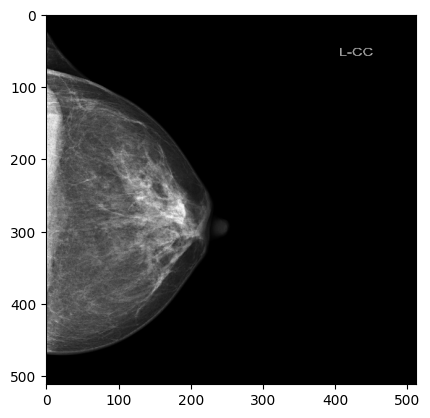

In [27]:
index = 4
print(df_train_rsna['image_path'].iloc[index])
print(df_train_rsna['cancer'].iloc[index])
img = Image.open(df_train_rsna['image_path'].iloc[index]) 

print(np.array(img).shape)
plt.imshow(np.array(img), cmap="gray")

./images_rsna/10011_220375232.png
0
(512, 512)


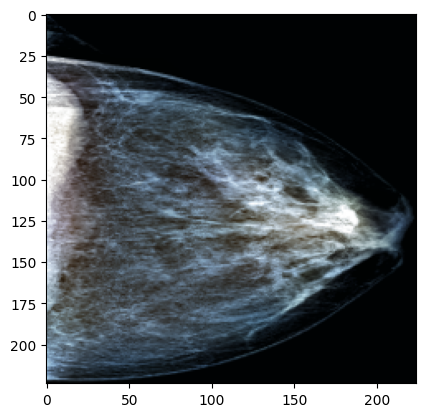

In [23]:
index = 4
print(df_train_rsna['image_path'].iloc[index])
print(df_train_rsna['cancer'].iloc[index])
img = Image.open(df_train_rsna['image_path'].iloc[index]) 

print(np.array(img).shape)
img_prep = process_image(df_train_rsna['image_path'].iloc[index])
plt.imshow(img_prep, cmap="gray")

./images_cmmd/D2-0230_1-3.png
1
(2048, 2048)


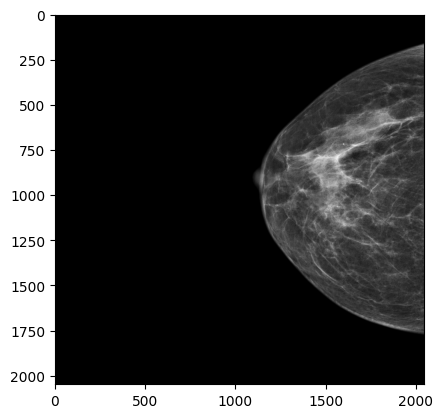

In [28]:
index = 4
print(df_train_cmmd['image_path'].iloc[index])
print(df_train_cmmd['cancer'].iloc[index])
img = Image.open(df_train_cmmd['image_path'].iloc[index]) 

print(np.array(img).shape)
plt.imshow(np.array(img), cmap="gray")

./images_cmmd/D2-0230_1-3.png
1
(2048, 2048)


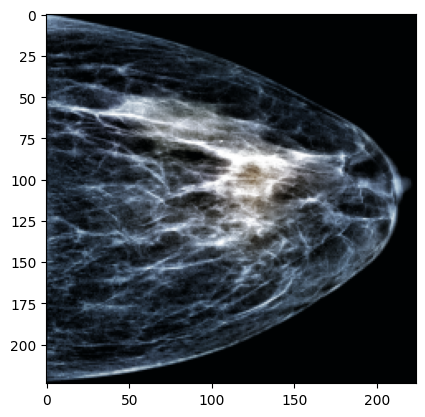

In [24]:
index = 4
print(df_train_cmmd['image_path'].iloc[index])
print(df_train_cmmd['cancer'].iloc[index])
img = Image.open(df_train_cmmd['image_path'].iloc[index]) 

print(np.array(img).shape)
img_prep = process_image(df_train_cmmd['image_path'].iloc[index])
plt.imshow(img_prep, cmap="gray")

./images_inbreast/20587054_b6a4f750c6df4f90_MG_R_CC_ANON.png
1
(3328, 2560)


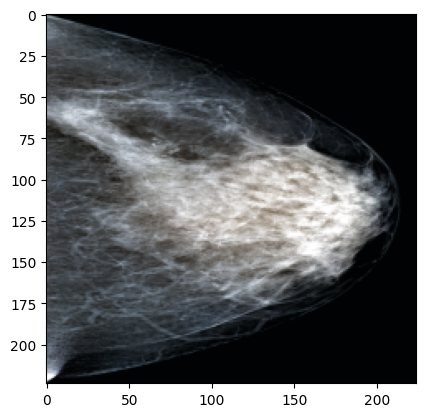

In [25]:
index = 4
print(df_train_inbreast['image_path'].iloc[index])
print(df_train_inbreast['cancer'].iloc[index])
img = Image.open(df_train_inbreast['image_path'].iloc[index]) 

print(np.array(img).shape)
img_prep = process_image(df_train_inbreast['image_path'].iloc[index])
plt.imshow(img_prep, cmap="gray")

In [ ]:
os.makedirs(SAVE_FOLDER, exist_ok=True)

## Create Dataset

In [40]:
print("rsna:",len(df_train_rsna))
print("cmmd:",len(df_train_cmmd))
print("inbreast:",len(df_train_inbreast))
print()
print("rsna--1:",len(df_train_rsna[df_train_rsna.cancer == 1]))
print("cmmd--1:",len(df_train_cmmd[df_train_cmmd.cancer == 1]))
print("inbreast--1:",len(df_train_inbreast[df_train_inbreast.cancer == 1]))
print()
print("rsna--0:",len(df_train_rsna[df_train_rsna.cancer == 0]))
print("cmmd--0:",len(df_train_cmmd[df_train_cmmd.cancer == 0]))
print("inbreast--0:",len(df_train_inbreast[df_train_inbreast.cancer == 0]))

rsna: 54706
cmmd: 5202
inbreast: 410

rsna--1: 1158
cmmd--1: 4094
inbreast--1: 77

rsna--0: 53548
cmmd--0: 1108
inbreast--0: 333


In [26]:
os.makedirs(SAVE_FOLDER, exist_ok=True)

df_train_cancer_rsna = df_train_rsna[df_train_rsna.cancer == 1]
df_train_healthy_rsna = df_train_rsna[(df_train_rsna.cancer == 0)]

#df_train_cancer = df_train[(df_train.cancer == 1) & (df_train.view == "CC")]
#df_train_healthy = df_train[(df_train.cancer == 0) & (df_train.view == "CC")]
df_train_implant = df_train_rsna[df_train_rsna.implant == 1]
df_train_cancer_cmmd = df_train_cmmd[df_train_cmmd.cancer == 1]

df_train_cancer_inbreast = df_train_inbreast[df_train_inbreast.cancer == 1]

df_train_healthy_sampled_rsna = df_train_healthy_rsna.sample(n = len(df_train_cancer_rsna) + len(df_train_cancer_cmmd) + len(df_train_cancer_inbreast))

df_train_subset = pd.concat([df_train_cancer_rsna, df_train_cancer_cmmd, df_train_cancer_inbreast, df_train_healthy_sampled_rsna], ignore_index = True)
print(df_train_subset.shape)
df_train_subset.head()

(10658, 25)


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,...,Dataset,ID,Abnormality,Subtype,Path,Method_crop,Patient ID,Acquisition date,DG,File Name
0,1.0,10130.0,3.888120e+08,L,MLO,71.0,1,1.0,1.0,0.0,...,rsna,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,10130.0,6.134626e+08,L,CC,71.0,1,1.0,1.0,0.0,...,rsna,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1.0,10130.0,1.360339e+09,L,CC,71.0,1,1.0,1.0,0.0,...,rsna,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1.0,10130.0,1.672637e+09,L,MLO,71.0,1,1.0,1.0,0.0,...,rsna,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.0,10226.0,4.616148e+08,L,MLO,71.0,1,1.0,1.0,0.0,...,rsna,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
for image_path in tqdm(df_train_subset["image_path"]):
    patient = image_path.split('/')[-1][:-4]
    processed_img = process_image(image_path)
    cv2.imwrite(f"{SAVE_FOLDER}/{patient}.png", processed_img)

  0%|          | 0/10658 [00:00<?, ?it/s]

In [28]:
df_train_subset["processed_img_path"] = SAVE_FOLDER + '/' +\
df_train_subset["image_path"].str.extract(r"([ \w-]+\.png)")

df_train_subset.to_csv("./output/df_train_subset_rsna+cddm+inbreast.csv")

## Create Dataset [Only RSNA Test]

In [29]:
# Output
DATASET_NAME_TEST = f"RSNA_TEST"
SAVE_FOLDER_TEST = f"./output/{DATASET_NAME_TEST}"

DATASET_NAME_TRAIN = f"RSNA+CCDM+INBREAST_TRAIN"
SAVE_FOLDER_TRAIN = f"./output/{DATASET_NAME_TRAIN}"

In [27]:
print("rsna:",len(df_train_rsna))
print("cmmd:",len(df_train_cmmd))
print("inbreast:",len(df_train_inbreast))
print()
print("rsna--1:",len(df_train_rsna[df_train_rsna.cancer == 1]))
print("cmmd--1:",len(df_train_cmmd[df_train_cmmd.cancer == 1]))
print("inbreast--1:",len(df_train_inbreast[df_train_inbreast.cancer == 1]))
print("TOTAL:",len(df_train_rsna[df_train_rsna.cancer == 1])+len(df_train_cmmd[df_train_cmmd.cancer == 1])+len(df_train_inbreast[df_train_inbreast.cancer == 1]))
print()
print("rsna--0:",len(df_train_rsna[df_train_rsna.cancer == 0]))
print("cmmd--0:",len(df_train_cmmd[df_train_cmmd.cancer == 0]))
print("inbreast--0:",len(df_train_inbreast[df_train_inbreast.cancer == 0]))

rsna: 54706
cmmd: 5202
inbreast: 410

rsna--1: 1158
cmmd--1: 4094
inbreast--1: 77
TOTAL: 5329

rsna--0: 53548
cmmd--0: 1108
inbreast--0: 333


In [28]:
# split rsna
df_train_rsna_copy = df_train_rsna[df_train_rsna.implant == 0]

df_train_rsna_copy_cancer1 = df_train_rsna_copy[df_train_rsna_copy.cancer==1]
df_train_rsna_copy_cancer0 = df_train_rsna_copy[df_train_rsna_copy.cancer==0]

n_test = int(0.2*len(df_train_rsna_copy_cancer1))

df_train_rsna_copy_cancer1_test = df_train_rsna_copy_cancer1.sample(n = n_test)
print(len(df_train_rsna_copy_cancer1_test))

229


In [30]:
df_train_rsna_copy_cancer1_test.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,image_path,Dataset
53476,2,865,806916891,R,MLO,55.0,1,1,0,NaN,0,NaN,21,False,./images_rsna/865_806916891.png,rsna
23427,2,34992,204545103,R,MLO,67.0,1,1,1,NaN,0,NaN,48,False,./images_rsna/34992_204545103.png,rsna
23840,1,3542,14104315,R,MLO,68.0,1,1,1,0.0,0,A,190,False,./images_rsna/3542_14104315.png,rsna
24964,1,3670,87674192,R,CC,66.0,1,1,1,0.0,0,C,49,False,./images_rsna/3670_87674192.png,rsna
26132,1,37931,1892232224,L,MLO,73.0,1,1,1,0.0,0,B,49,False,./images_rsna/37931_1892232224.png,rsna


In [31]:
df_train_rsna_copy_cancer1_test
image_id_rsna_cancer1_test = df_train_rsna_copy_cancer1_test.image_id.tolist()
print(image_id_rsna_cancer1_test)
print(len(image_id_rsna_cancer1_test))

[806916891, 204545103, 14104315, 87674192, 1892232224, 2019751492, 1307198725, 345896545, 640156723, 857882013, 1690877249, 2102657462, 701160320, 598556705, 701842729, 1928377168, 1710665236, 104106029, 1291878323, 638253126, 623014940, 1928170517, 623439984, 782049033, 317530806, 476723525, 1084474740, 204685133, 800356528, 303808170, 1270133082, 1034477468, 1705616801, 1016408119, 776707293, 834999110, 2052987229, 525083202, 740439778, 382701440, 458553546, 1314799188, 981350543, 1829910078, 355971526, 744035306, 2037343606, 1151546567, 1203123196, 1177448351, 218465248, 1900457997, 1159321127, 797737008, 874812410, 1656688953, 680464985, 55676960, 75408744, 1322837831, 238763713, 1239502036, 831671840, 326844470, 1874310597, 991310893, 941185309, 873474308, 1220490070, 1368532850, 1243050806, 952275239, 714251521, 563798715, 732919056, 1773963138, 2061693834, 1506392319, 965929379, 1766220026, 513700051, 238197258, 444459118, 449544592, 1534271742, 1044828729, 1925841866, 144545889

In [32]:
df_train_rsna_copy_cancer1_train = df_train_rsna_copy_cancer1

for index, row in df_train_rsna_copy_cancer1_train.iterrows():
    for img_id in image_id_rsna_cancer1_test:
        if row["image_id"] == img_id:
            # print(index)
            df_train_rsna_copy_cancer1_train = df_train_rsna_copy_cancer1_train.drop(index=index)

print(len(df_train_rsna_copy_cancer1_train))


916


In [33]:
#check
print(len(df_train_rsna_copy_cancer1_train)+len(df_train_rsna_copy_cancer1_test))
print("rsna--1:",len(df_train_rsna[df_train_rsna.cancer == 1]))

# check intersection
intersection_df_rsna_cancer1 = pd.merge(df_train_rsna_copy_cancer1_train, df_train_rsna_copy_cancer1_test, how ='inner')
print(len(intersection_df_rsna_cancer1))



1145
rsna--1: 1158
0


In [36]:
# CMMD 
df_train_ccmmd_cancer1= df_train_cmmd[df_train_cmmd.cancer == 1]
df_train_ccmmd_cancer0= df_train_cmmd[df_train_cmmd.cancer == 0]
print("cmmd 0:",len(df_train_ccmmd_cancer0))
print("cmmd 1:",len(df_train_ccmmd_cancer1))
print("TOTAL:",len(df_train_cmmd),"\n")


# InBreast
df_train_inbreast_cancer1 = df_train_inbreast[df_train_inbreast.cancer == 1]
df_train_inbreast_cancer0 = df_train_inbreast[df_train_inbreast.cancer == 0]
print("inbreast 0:",len(df_train_inbreast_cancer0))
print("inbreast 1:",len(df_train_inbreast_cancer1))
print("TOTAL:",len(df_train_inbreast))

cmmd 0: 1108
cmmd 1: 4094
TOTAL: 5202 

inbreast 0: 333
inbreast 1: 77
TOTAL: 410


In [62]:
# cancer DF
df_subset_cancer1 = pd.concat([df_train_rsna_copy_cancer1_train, df_train_ccmmd_cancer1, df_train_inbreast_cancer1], ignore_index = True)
len_subset_cancer1 = len(df_subset_cancer1)
print("len cancer1:",len_subset_cancer1)
print(len(df_train_rsna_copy_cancer1_train))
print(len(df_train_ccmmd_cancer1))
print(len(df_train_inbreast_cancer1))

len cancer1: 5087
916
4094
77


In [65]:
# create [TRAIN]RSNA Cancer_0

df_train_rsna_copy_cancer0_train = df_train_rsna_copy_cancer0.sample(n= len_subset_cancer1)

image_id_rsna_cancer0_train = df_train_rsna_copy_cancer0_train.image_id.tolist()
print(image_id_rsna_cancer0_train)
print(len(image_id_rsna_cancer0_train))

[901398975, 2096910634, 1336355418, 823359764, 1208494128, 427814214, 1937215365, 389206468, 1004752758, 1992109729, 1503054224, 437851444, 913152920, 810995372, 268980259, 380119316, 276306007, 561161967, 386276156, 859651588, 797388117, 1264710861, 799944340, 1663808733, 160022046, 236986445, 136490988, 1289703450, 684979201, 1095406834, 720406038, 938227703, 1866282903, 177884920, 2117649440, 689241087, 2071502109, 561107928, 1267972137, 539555631, 1555590201, 381296825, 1062821506, 1678909753, 958490837, 76191651, 2045259132, 48112509, 525762508, 765790801, 801065413, 1345441828, 2054431371, 800765600, 255048414, 763366401, 1756803479, 1915026110, 1515666251, 579841204, 1597633932, 2096229202, 458649900, 1976472767, 1363831396, 2101614615, 54606396, 1233458498, 709200770, 482329881, 1116400244, 1783362471, 573119264, 938130870, 1543774075, 737467245, 986169342, 168175389, 1675260027, 191475167, 787364727, 50303129, 2115013473, 606304717, 1173438175, 1134471442, 2044220738, 11618058

In [66]:
df_train_rsna_copy_cancer0_test = df_train_rsna_copy_cancer0

for index, row in df_train_rsna_copy_cancer0_test.iterrows():
    if index % 1000 == 0:
        print(index)

    for img_id in image_id_rsna_cancer0_train:
        if row["image_id"] == img_id:
            # print(index)
            df_train_rsna_copy_cancer0_test = df_train_rsna_copy_cancer0_test.drop(index=index)

print(len(df_train_rsna_copy_cancer0_test))

0
1000
3000
5000
6000
8000
9000
10000
11000
12000
13000
14000
15000
17000
18000
19000
20000
21000
22000
23000
24000
25000
26000
27000
28000
29000
30000
31000
32000
33000
34000
35000
36000
37000
38000
39000
40000
41000
42000
43000
44000
45000
46000
47000
48000
49000
50000
51000
52000
53000
54000
46997


In [67]:
print(len(df_train_rsna_copy_cancer0_test))
print(len(df_train_rsna_copy_cancer0_train))


46997
5087


In [68]:
print(len(df_train_rsna_copy_cancer0_test)+len(image_id_rsna_cancer0_train))
print(len(df_train_rsna_copy_cancer0))

52084
52084


In [69]:
df_train_rsna_copy_cancer0_test_undersampled = df_train_rsna_copy_cancer0_test.sample(n=len(df_train_rsna_copy_cancer1_test))
print(len(df_train_rsna_copy_cancer0_test_undersampled))

229


In [70]:
########################################################## train
# # RSNA Cancer_0
# df_train_rsna_copy_cancer0_train

# # CMMD Cancer_0
# df_train_ccmmd_cancer0

# # InBreast Cancer_0
# df_train_inbreast_cancer0

################################ or

# # RSNA Cancer_0
# df_train_rsna_copy_cancer0_train

##########################################################
# # RSNA Cancer_1
# df_train_rsna_copy_cancer1_train

# # CMMD Cancer_1
# df_train_ccmmd_cancer1

# # InBreast Cancer_1
# df_train_inbreast_cancer1

df_train_cancer_0_all = df_train_rsna_copy_cancer0_train
# df_train_cancer_0_all = pd.concat([df_train_rsna_copy_cancer0_train, df_train_ccmmd_cancer0, df_train_inbreast_cancer0], ignore_index = True)
df_train_cancer_1_all = pd.concat([df_train_rsna_copy_cancer1_train, df_train_ccmmd_cancer1, df_train_inbreast_cancer1], ignore_index = True)
df_train_all = pd.concat([df_train_cancer_0_all, df_train_cancer_1_all], ignore_index = True)


########################################################## test
# RSNA Cancer_0
df_train_rsna_copy_cancer0_test_undersampled
# RSNA Cancer_1 
df_train_rsna_copy_cancer1_test

df_test_all = pd.concat([df_train_rsna_copy_cancer0_test_undersampled, df_train_rsna_copy_cancer1_test], ignore_index = True)

df_all = pd.concat([df_train_all, df_test_all], ignore_index = True)

In [73]:
print(len(df_train_rsna_copy_cancer1_train[df_train_rsna_copy_cancer1_train.cancer==1]))
print(len(df_train_ccmmd_cancer1[df_train_ccmmd_cancer1.cancer==1]))
print(len(df_train_inbreast_cancer1[df_train_inbreast_cancer1.cancer==1]))
print(len(df_train_rsna_copy_cancer1_train[df_train_rsna_copy_cancer1_train.cancer==1])+len(df_train_ccmmd_cancer1[df_train_ccmmd_cancer1.cancer==1]) +len(df_train_inbreast_cancer1[df_train_inbreast_cancer1.cancer==1]))
print()
print(len(df_train_rsna_copy_cancer0_train[df_train_rsna_copy_cancer0_train.cancer==0]))
print(len(df_train_ccmmd_cancer0[df_train_ccmmd_cancer0.cancer==0]))
print(len(df_train_inbreast_cancer0[df_train_inbreast_cancer0.cancer==0]))
print()

916
4094
77
5087

5087
1108
333



In [74]:
print(df_train_all.shape)
print(df_test_all.shape)
print(df_all.shape)
print()

print(len(df_train_all[df_train_all.cancer==1]))
print(len(df_train_all[df_train_all.cancer==0]))
print()

print(len(df_test_all[df_test_all.cancer==1]))
print(len(df_test_all[df_test_all.cancer==0]))


(10174, 25)
(458, 16)
(10632, 25)

5087
5087

229
229


In [ ]:
# os.makedirs(SAVE_FOLDER, exist_ok=True)

# df_train_cancer_rsna = df_train_rsna[df_train_rsna.cancer == 1]
# df_train_healthy_rsna = df_train_rsna[(df_train_rsna.cancer == 0)]

# #df_train_cancer = df_train[(df_train.cancer == 1) & (df_train.view == "CC")]
# #df_train_healthy = df_train[(df_train.cancer == 0) & (df_train.view == "CC")]
# df_train_implant = df_train_rsna[df_train_rsna.implant == 1]
# df_train_cancer_cmmd = df_train_cmmd[df_train_cmmd.cancer == 1]

# df_train_cancer_inbreast = df_train_inbreast[df_train_inbreast.cancer == 1]

# df_train_healthy_sampled_rsna = df_train_healthy_rsna.sample(n = len(df_train_cancer_rsna) + len(df_train_cancer_cmmd) + len(df_train_cancer_inbreast))

# df_train_subset = pd.concat([df_train_cancer_rsna, df_train_cancer_cmmd, df_train_cancer_inbreast, df_train_healthy_sampled_rsna], ignore_index = True)
# print(df_train_subset.shape)
# df_train_subset.head()

# save images and CSV

In [77]:
# Output
DATASET_NAME_TEST = f"Test_RSNA"
SAVE_FOLDER_TEST = f"./output/{DATASET_NAME_TEST}"

DATASET_NAME_TRAIN = f"Train_RSNA+CCDM+INBREAST"
SAVE_FOLDER_TRAIN = f"./output/{DATASET_NAME_TRAIN}"

In [78]:
os.makedirs(SAVE_FOLDER_TEST, exist_ok=True)
os.makedirs(SAVE_FOLDER_TRAIN, exist_ok=True)

# train

In [79]:
for image_path in tqdm(df_train_all["image_path"]):
    patient = image_path.split('/')[-1][:-4]
    processed_img = process_image(image_path)
    cv2.imwrite(f"{SAVE_FOLDER_TRAIN}/{patient}.png", processed_img)

  0%|          | 0/10174 [00:00<?, ?it/s]

In [80]:
df_train_all["processed_img_path"] = SAVE_FOLDER_TRAIN + '/' +\
df_train_all["image_path"].str.extract(r"([ \w-]+\.png)")

df_train_all.to_csv("./output/df_train_all_v2.csv")

# test


In [81]:
for image_path in tqdm(df_test_all["image_path"]):
    patient = image_path.split('/')[-1][:-4]
    processed_img = process_image(image_path)
    cv2.imwrite(f"{SAVE_FOLDER_TEST}/{patient}.png", processed_img)

  0%|          | 0/458 [00:00<?, ?it/s]

In [ ]:
df_test_all["processed_img_path"] = SAVE_FOLDER_TEST + '/' +\
df_test_all["image_path"].str.extract(r"([ \w-]+\.png)")

df_test_all.to_csv("./output/df_test_all_v2.csv")

# check

In [31]:
df_train_subset.head()

,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,...,ID,Abnormality,Subtype,Path,Method_crop,Patient ID,Acquisition date,DG,File Name,processed_img_path
0,1.0,10130.0,3.888120e+08,L,MLO,71.0,1,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,./output/RSNA+CCDM+INBREAST/10130_388811999.png
1,1.0,10130.0,6.134626e+08,L,CC,71.0,1,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,./output/RSNA+CCDM+INBREAST/10130_613462606.png
2,1.0,10130.0,1.360339e+09,L,CC,71.0,1,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,./output/RSNA+CCDM+INBREAST/10130_1360338805.png
3,1.0,10130.0,1.672637e+09,L,MLO,71.0,1,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,./output/RSNA+CCDM+INBREAST/10130_1672636630.png
4,1.0,10226.0,4.616148e+08,L,MLO,71.0,1,1.0,1.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,./output/RSNA+CCDM+INBREAST/10226_461614796.png


In [32]:
df_train_subset.columns

Index(['site_id', 'patient_id', 'image_id', 'laterality', 'view', 'age',
       'cancer', 'biopsy', 'invasive', 'BIRADS', 'implant', 'density',
       'machine_id', 'difficult_negative_case', 'image_path', 'Dataset', 'ID',
       'Abnormality', 'Subtype', 'Path', 'Method_crop', 'Patient ID',
       'Acquisition date', 'DG', 'File Name', 'processed_img_path'],
      dtype='object')

In [34]:
df_train_subset_cancer0 = df_train_subset[df_train_subset.cancer ==0]
df_train_subset_cancer1 = df_train_subset[df_train_subset.cancer ==1]

In [38]:
print(len(os.listdir(SAVE_FOLDER)))
print("-------------")
print(len(df_train_subset))
print("-------------")
print(len(df_train_subset_cancer0))
print(len(df_train_subset_cancer1))
print("total:",len(df_train_subset_cancer0)+len(df_train_subset_cancer1))

10658
-------------
10658
-------------
5329
5329
total: 10658


# check test-train

In [2]:
df_test_all_2 = pd.read_csv("./output/df_test_all_v2.csv")
df_train_all_2 = pd.read_csv("./output/df_train_all_v2.csv")

In [3]:
df_test_all_2.head()

,Unnamed: 0,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,image_path,Dataset,processed_img_path
0,0,2,14418,130417008,R,MLO,50.0,0,0,0,NaN,0,NaN,29,False,./images_rsna/14418_130417008.png,rsna,./output/Test_RSNA/14418_130417008.png
1,1,1,28785,481979273,R,CC,65.0,0,0,0,NaN,0,B,49,False,./images_rsna/28785_481979273.png,rsna,./output/Test_RSNA/28785_481979273.png
2,2,1,3765,1980124096,R,CC,62.0,0,1,0,0.0,0,B,93,True,./images_rsna/3765_1980124096.png,rsna,./output/Test_RSNA/3765_1980124096.png
3,3,2,24277,1913276279,R,MLO,56.0,0,0,0,NaN,0,NaN,29,False,./images_rsna/24277_1913276279.png,rsna,./output/Test_RSNA/24277_1913276279.png
4,4,1,3676,209402854,R,MLO,44.0,0,0,0,1.0,0,C,49,False,./images_rsna/3676_209402854.png,rsna,./output/Test_RSNA/3676_209402854.png


In [8]:
df_train_all_2[df_train_all_2.Dataset == "inbreast"]

,Unnamed: 0,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,...,ID,Abnormality,Subtype,Path,Method_crop,Patient ID,Acquisition date,DG,File Name,processed_img_path
10097,10097,NaN,NaN,NaN,NaN,NaN,68.0,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10455721.0,20090826.0,NaN,22678646.0,./output/Train_RSNA+CCDM+INBREAST/20586934_6c6...
10098,10098,NaN,NaN,NaN,NaN,NaN,68.0,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10455721.0,20090826.0,NaN,22678694.0,./output/Train_RSNA+CCDM+INBREAST/20586986_6c6...
10099,10099,NaN,NaN,NaN,NaN,NaN,64.0,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10904633.0,20090825.0,CDIS,22614074.0,./output/Train_RSNA+CCDM+INBREAST/20587054_b6a...
10100,10100,NaN,NaN,NaN,NaN,NaN,64.0,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10904633.0,20090825.0,NaN,22614097.0,./output/Train_RSNA+CCDM+INBREAST/20587080_b6a...
10101,10101,NaN,NaN,NaN,NaN,NaN,61.0,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10026765.0,20090901.0,Ca Invasor,22580244.0,./output/Train_RSNA+CCDM+INBREAST/20587612_f4b...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10169,10169,NaN,NaN,NaN,NaN,NaN,63.0,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10514189.0,20100302.0,NaN,24065270.0,./output/Train_RSNA+CCDM+INBREAST/53580858_51b...
10170,10170,NaN,NaN,NaN,NaN,NaN,51.0,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,11599041.0,20100309.0,NaN,50997651.0,./output/Train_RSNA+CCDM+INBREAST/53581406_b23...
10171,10171,NaN,NaN,NaN,NaN,NaN,51.0,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,11599041.0,20100309.0,NaN,50995872.0,./output/Train_RSNA+CCDM+INBREAST/53581460_b23...
10172,10172,NaN,NaN,NaN,NaN,NaN,72.0,1,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10952189.0,20100204.0,Ca Invasor,50994300.0,./output/Train_RSNA+CCDM+INBREAST/53582656_465...


In [9]:
print(len(df_train_all_2))
print(len(df_test_all_2))

10174
458
